# Image Classification - The Multi-class Weather Dataset



##  Data exploration, preparation, and partition

###  data partition 

I will generate three CSV files named `my_training.csv`, `my_validation.csv`, and `my_test.csv` that partition the dataset into the training, validation, and test set. Each CSV file contains the following two fields:

- File path
- Image label

For example, the file `my_training.csv` could start like this:

```csv
dataset2/cloudy1.jpg,cloudy
dataset2/shine170.jpg,shine
dataset2/shine116.jpg,shine
```

I will Make sure that the partitions are created randomly, so that the label distribution is similar in each partition. Also, make sure that the samples are sorted in no particular order (randomly)

Then I'll display the label distribution of each partition, and display the first 10 rows of each partition.






In [51]:
import os
import pandas as pd
import re

def create_partition_csv(dataset_dir, label_names, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42):
    file_paths = []
    labels = []
    label_pattern = re.compile(r'^([a-zA-Z]+)')
    #iterating over all files in the dataset directory
    for file in os.listdir(dataset_dir):
        if file.endswith(".jpg"):
            file_paths.append(os.path.join(dataset_dir, file))
            #extracting label from the filename using regular expressions
            match = label_pattern.match(file)
            if match:
                label = match.group(1)
                labels.append(label)
    #creating a DataFrame with file paths and corresponding labels
    df = pd.DataFrame({'File_Path': file_paths, 'Label': labels})
    #shuffling the DataFrame
    df = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
    #calculating the number of samples for each partition
    num_samples = len(df)
    num_train = int(train_ratio * num_samples)
    num_val = int(val_ratio * num_samples)
    #spliting the DataFrame into train, validation, and test sets
    train_df = df.iloc[:num_train]
    val_df = df.iloc[num_train:num_train+num_val]
    test_df = df.iloc[num_train+num_val:]
    #saving the partition information to CSV files
    train_df.to_csv(os.path.join( 'my_training.csv'), index=False)
    val_df.to_csv(os.path.join( 'my_validation.csv'), index=False)
    test_df.to_csv(os.path.join('my_test.csv'), index=False)
    partitions = {'Training': train_df, 'Validation': val_df, 'Test': test_df}
    for partition_name, partition_df in partitions.items():
        print(f"{partition_name} Partition:")
        print("Label Distribution:")
        print(partition_df['Label'].value_counts())
        print("\nFirst 10 Rows:")
        print(partition_df.head(10))
        print("\n")

In [52]:
label_names = ['cloudy', 'rain', 'shine', 'sunrise']

In [53]:
dataset_dir = "dataset2"
create_partition_csv(dataset_dir, label_names)

Training Partition:
Label Distribution:
Label
sunrise    235
cloudy     216
shine      181
rain       153
Name: count, dtype: int64

First 10 Rows:
                 File_Path    Label
0  dataset2\sunrise283.jpg  sunrise
1  dataset2\sunrise150.jpg  sunrise
2   dataset2\cloudy186.jpg   cloudy
3     dataset2\shine54.jpg    shine
4   dataset2\sunrise45.jpg  sunrise
5  dataset2\sunrise151.jpg  sunrise
6     dataset2\rain172.jpg     rain
7   dataset2\sunrise66.jpg  sunrise
8    dataset2\cloudy24.jpg   cloudy
9    dataset2\shine204.jpg    shine


Validation Partition:
Label Distribution:
Label
sunrise    69
cloudy     44
shine      28
rain       27
Name: count, dtype: int64

First 10 Rows:
                   File_Path    Label
785  dataset2\sunrise176.jpg  sunrise
786       dataset2\rain7.jpg     rain
787    dataset2\cloudy84.jpg   cloudy
788  dataset2\sunrise210.jpg  sunrise
789  dataset2\sunrise141.jpg  sunrise
790    dataset2\cloudy31.jpg   cloudy
791   dataset2\cloudy122.jpg   cloudy
792 

###  preprocessing and preparation 

Use TensorFlow's `TextLineDataset` to generate datasets for training, validation, and test. The datasets need to produce images that are re-sized to dimensions 230 x 230 and 3 channels, and the values of the pixels must be normalised to the range [0, 1].


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
import keras_tuner as kt
import tensorflow_hub as hub
import os

In [81]:
#we redefine read_and decode so that it uses TensorFlow's tensors
label_names = ['cloudy', 'rain', 'shine', 'sunrise']
def read_and_decode(filename, reshape_dims):

  #reading the file
  img = tf.io.read_file(filename)

  #converting the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=3)

  #using convert_image_dtype to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  #resizing the image to the desired size.
  return tf.image.resize(img, reshape_dims)

#decode_csv changed so that the label is the inden into CLASS_NAMES array
def decode_csv(csv_row):

  record_defaults = ["path", "label"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [230, 230])
  label = tf.math.equal(label_names, label_string) 

  return img, label


train_dataset = (
    tf.data.TextLineDataset("training.csv").map(decode_csv).batch(32)
)

val_dataset = (
    tf.data.TextLineDataset("validation.csv").map(decode_csv).batch(32)
)

test_dataset = (
    tf.data.TextLineDataset("test.csv").map(decode_csv).batch(32)
)


In [57]:
for images, labels in train_dataset.take(25):
    print(images.shape) 

(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(32, 230, 230, 3)
(13, 230, 230, 3)


##  A simple classifier

### First classifier 

Create a simple model that contains the following layers:

- A `Flatten` layer.
- The output layer with the correct size and activation function for this classification task.

Then, train the model with the training data. Use the validation data to determine when to stop training. Finally, test the trained model on the test data and report the accuracy.

In [68]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(230, 230, 3)))#flatten layer
model.add(layers.Dense(128, activation='relu'))#dense layer with ReLU activation
model.add(layers.Dense(4, activation='softmax'))#output layer with softmax activation for 4 classes
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 158700)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │    20,313,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,314,244 (77.49 MB)

 Trainable params: 20,314,244 (77.49 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.3432 - loss: 81.9981 - val_accuracy: 0.6347 - val_loss: 1.4969
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.6883 - loss: 1.9512 - val_accuracy: 0.7066 - val_loss: 1.3339
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - accuracy: 0.7281 - loss: 1.3414 - val_accuracy: 0.6886 - val_loss: 1.3242
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.7555 - loss: 0.9365 - val_accuracy: 0.7365 - val_loss: 0.7133
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7212 - loss: 1.1110 - val_accuracy: 0.7246 - val_loss: 1.0256
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.7240 - loss: 1.3593 - val_accuracy: 0.7126 - val_loss: 1.0776
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7075 - loss: 1.2172 - val_accuracy: 0.6108 - val_loss: 1.4806
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.7322 - loss: 1.0569 - val_accuracy: 0.748

#### Accuracy
in the cell below i wrote the code that displays the accuracy of the model on the test_data

In [70]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Test Accuracy:', test_accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6819 - loss: 1.4461
Test Accuracy: 0.7041420340538025


the accuracy of the model is : 0.7041420340538025

### A more complex classifier
Try a more complex architecture that has 1 or more hidden layers with dropout. For this more complex architecture, use `keras-tuner` and run it with a reasonable choice of possible parameters. You may try among the following:

- Number of hidden layers
- Sizes of hidden layers
- Dropout rate
- Learning rate

In [62]:
#defining the parameters (you can adjust these as needed)
def build_model(hp):
    lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log')
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(230, 230, 3)))  #flatten layer
    #number of hidden layers
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=3, default=1)
    for i in range(num_hidden_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=512, step=32)
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.9, step=0.1)
        model.add(keras.layers.Dense(units=units, activation='relu'))
        model.add(keras.layers.Dropout(dropout_rate))
    #output layer
    model.add(keras.layers.Dense(4, activation='softmax'))  #output layer with softmax activation for 4 classes
    #compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lrate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
#initialize the tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    num_initial_points=2,
    overwrite=True  #true to start afresh
)
#search for the best hyperparameters
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[keras.callbacks.EarlyStopping(patience=1)]
)
#get the best hyperparameters and model summary
topN = 1
for x in range(topN):
    print(tuner.get_best_hyperparameters(topN)[x].values)
    print(tuner.get_best_models(topN)[x].summary())


Trial 10 Complete [00h 00m 40s]
val_accuracy: 0.7544910311698914

Best val_accuracy So Far: 0.772455096244812
Total elapsed time: 00h 04m 49s
{'lrate': 0.0016772511235787196, 'num_hidden_layers': 1, 'units_0': 384, 'dropout_0': 0.2, 'units_1': 32, 'dropout_1': 0.0, 'units_2': 32, 'dropout_2': 0.0}


C:\Users\amirs\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 158700)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 384)            │    60,941,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,942,724 (232.48 MB)

 Trainable params: 60,942,724 (232.48 MB)

 Non-trainable params: 0 (0.00 B)

None


In [64]:
best_model = keras.Sequential()
best_model.add(keras.layers.Flatten(input_shape=(230, 230, 3)))
best_model.add(keras.layers.Dense(units=384, activation='relu'))
best_model.add(keras.layers.Dropout(0.2))
best_model.add(keras.layers.Dense(4, activation='softmax'))
best_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0016772511235787196),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
best_model.summary()
history = best_model.fit(train_dataset, validation_data=val_dataset, epochs=5)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 158700)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 384)            │    60,941,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,540 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,942,724 (232.48 MB)

 Trainable params: 60,942,724 (232.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - accuracy: 0.3242 - loss: 170.0759 - val_accuracy: 0.5928 - val_loss: 17.3159
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - accuracy: 0.6431 - loss: 29.2969 - val_accuracy: 0.7545 - val_loss: 4.3645
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.6946 - loss: 5.2566 - val_accuracy: 0.7665 - val_loss: 1.0583
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.7129 - loss: 0.7957 - val_accuracy: 0.7545 - val_loss: 0.8654
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 205ms/step - accuracy: 0.7540 - loss: 0.6760 - val_accuracy: 0.7126 - val_loss: 0.8668


Write text below where you explain and justify your decision choices made in this task.

#### Justification
in this task i was required to write use keras tuner to create a complex model with one or more hidden layers so i used a for loop to test different number of layers between 1 to 3 and find the best, for the number of nodes or neurons in each layer i wanted to test a number between 32 and 512 with a step size of 32 so it does test the different sizes of layers to train the model, for the drop out rate i wanted to be between 0 and 0.9 since the dropout rate of 1 would be dropping the whole nodes of layer which is not ideal, learning rate's min and max value is taken from the lecture slides which can be a common range to use for this purpose. Lastly i wanted the keras tuner to be searching through this range of different hyper parameters and pinpoint the optimal values for them to achieve the highest accuracy. i set the number of epochs in this task to 5 because it would've taken much more computing power and time to use higher number of epochs.

### 2.3 Error analysis (1 mark)

Evaluate your best-performing system from task 2 against the system of task 1 and answer the following questions.

1. Which system had a better accuracy on the test data?
2. Which system had a lower degree of overfitting?

In [76]:
test_loss_simple, test_accuracy_simple = model.evaluate(test_dataset)
print('Test Accuracy of Simple Classifier:', test_accuracy_simple)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6819 - loss: 1.4461
Test Accuracy of Simple Classifier: 0.7041420340538025


accuracy of the first model on test data: 0.7041420340538025

In [67]:
test_loss, test_accuracy = best_model.evaluate(test_dataset)
print("Test Accuracy:", test_accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7165 - loss: 0.6515
Test Accuracy: 0.7396449446678162


accuracy of the second model on test data: 0.7396449446678162

Best-performing model is the model trained for task 2.2 A more complex classifier, since i utilized keras-tuner to find out the optimal hyperparameters for the model. 
Which system had a better accuracy on the test data? the second model has a better accuracy on the test data
Which system had a lower degree of overfitting? based on my analysis of the models the second model has a lower degree of overfitting since the difference between the accuracy of the model on the validation data and the test data is less than the first model trained.

##### First model
best accuracy on validation data:  0.7849

accuracy on test data: 0.7041

this model is indicating a higher degree of overfitting since the accuracy drops significantly on test data

##### second model
best accuracy on validation data: 0.7724

accuracy on test data: 0.7396

this model showcases a lower degree of overfitting because the accuracy of the model changes less than the first model

##  A more complex classifier  

### Using ConvNets 

I'll implement a model that uses a sequence of at least two `ConvD`, each one followed with `MaxPooling2D`. Use reasonable numbers for the hyperparameters (number of filters, kernel size, pool size, activation, etc), base on what we have seen in the lectures. Feel free to research the internet and / or generative AI to help you find a reasonable choice of hyperparameters. For this task, do not use pre-trained models.

In [71]:
#defining the model
ConvNets_model = models.Sequential()
#convolutional layers
ConvNets_model.add(layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(230, 230, 3)))
ConvNets_model.add(layers.MaxPooling2D(pool_size=2))
ConvNets_model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
ConvNets_model.add(layers.MaxPooling2D(pool_size=2))
#flatten the output for Dense layers
ConvNets_model.add(layers.Flatten())
ConvNets_model.add(layers.Dense(4, activation="softmax"))  
#compiling the model
ConvNets_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.00001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

ConvNets_model.summary()


C:\Users\amirs\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 228, 228, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 114, 114, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │       802,820 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,212 (3.14 MB)

 Trainable params: 822,212 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

In [72]:
history = ConvNets_model.fit(train_dataset, validation_data=val_dataset,epochs=10,callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.3704 - loss: 1.3313 - val_accuracy: 0.5988 - val_loss: 1.0085
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.6695 - loss: 1.1232 - val_accuracy: 0.7066 - val_loss: 0.8672
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.7556 - loss: 0.9621 - val_accuracy: 0.8024 - val_loss: 0.7604
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.8104 - loss: 0.8483 - val_accuracy: 0.8084 - val_loss: 0.6834
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 354ms/step - accuracy: 0.8248 - loss: 0.7606 - val_accuracy: 0.8204 - val_loss: 0.6243
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.8302 - loss: 0.6908 - val_accuracy: 0.8144 - val_loss: 0.5772
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.8320 - loss: 0.6340 - val_accuracy: 0.8144 - val_loss: 0.5392
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 186ms/step - accuracy: 0.8381 - loss: 0.5882 - val_accuracy: 0.

In [73]:
test_loss, test_accuracy = ConvNets_model.evaluate(test_dataset)
print("Test Accuracy:", test_accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8124 - loss: 0.5004
Test Accuracy: 0.8284023404121399


Accuracy of the ConvNets model on test data is: 0.8284023404121399

### Using pre-trained models

Use MobileNet, pre-trained on imagenet as discussed in the lectures. Add the correct classification layer, and train it with your data. Make sure that you freeze MobileNet's weights during training. Also, make sure you use a reasonable schedule for the learning rate.

In [84]:
import tensorflow as tf
import tensorflow_hub as hub
import os

#loading compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

#defining a function to create the model
def create_model():
    premodel = tf.keras.Sequential(name='weather_classification')
    premodel.add(tf.keras.layers.InputLayer(input_shape=(224, 224, 3)))  #adjusted input shape for MobileNet model
    premodel.add(tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (224, 224))))  # Resize images
    premodel.add(tf.keras.layers.Lambda(lambda x: hub.KerasLayer(
        "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
        trainable=False)(x))) #to freeze MobileNet's weights during training
    premodel.add(tf.keras.layers.Dense(16, activation='relu', name='dense_hidden'))
    premodel.add(tf.keras.layers.Dense(4, activation='softmax', name='weather_prob'))
    return premodel

#function to train and evaluate the model
def train_and_evaluate(batch_size=32, lrate=0.001, num_hidden=16, epochs=10):
    train_dataset = (tf.data.TextLineDataset("training.csv")
                     .map(decode_csv)
                     .batch(batch_size))
    eval_dataset = (tf.data.TextLineDataset("validation.csv")
                    .map(decode_csv)
                    .batch(batch_size))

    premodel = create_model()
    premodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    print(premodel.summary())
    history = premodel.fit(train_dataset, validation_data=val_dataset, epochs=epochs,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)])
    return premodel

premodel = train_and_evaluate()


C:\Users\amirs\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "weather_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 16)             │        20,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ weather_prob (Dense)            │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,564 (80.33 KB)

 Trainable params: 20,564 (80.33 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.4004 - loss: 1.3790 - val_accuracy: 0.7425 - val_loss: 0.5226
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.8236 - loss: 0.4845 - val_accuracy: 0.9222 - val_loss: 0.2470
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.9230 - loss: 0.2400 - val_accuracy: 0.9401 - val_loss: 0.1762
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9499 - loss: 0.1617 - val_accuracy: 0.9461 - val_loss: 0.1515
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.9570 - loss: 0.1278 - val_accuracy: 0.9461 - val_loss: 0.1385
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9665 - loss: 0.1068 - val_accuracy: 0.9581 - val_loss: 0.1279
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.9699 - loss: 0.0909 - val_accuracy: 0.9581 - val_loss: 0.1185
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 152ms/step - accuracy: 0.9713 - loss: 0.0780 - val_accura

In [85]:
test_loss_simple, test_accuracy_simple = premodel.evaluate(test_dataset)
print('Test Accuracy of Simple Classifier:', test_accuracy_simple)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.9655 - loss: 0.0976
Test Accuracy of Simple Classifier: 0.9704142212867737


Accuracy of the ore-trained ConvNets model on test data is: 0.9704

### Comparative evaluation 

Here I Compare the evaluation results of the best systems from tasks previous models and answer the following questions.

1. What system perform best on the test set?
2. Report the accuracy of your best system on each of the different weather categories. What type of weather was most difficult to detect?

#### Best performing model

according to the model performance reports above this section the highest accuracy on test data is indicated when evaluating the pre-trained CNN model, it has a accuracy of 0.9704 on the test set while the other three have an accuracy of:

Accuracy of the first simple classifier model on test data: 0.7041

Accuracy of the more complex classifier model on test data: 0.7396

Accuracy of the ConvNets model on test data is:  0.8284

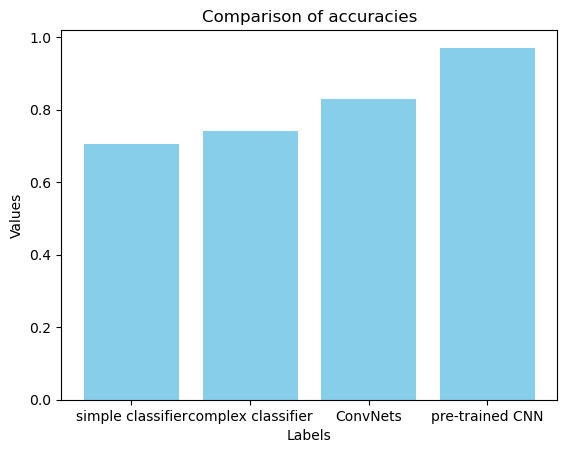

In [1]:
values = [0.7041, 0.7396, 0.8284, 0.9704]
labels = ['simple classifier', 'complex classifier', 'ConvNets', 'pre-trained CNN']
plt.bar(labels, values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Values')
plt.title('Comparison of accuracies')
plt.show()


In [87]:
#evaluating the model on the test dataset
test_loss, test_accuracy = premodel.evaluate(test_dataset)

#initializing dictionary to store counts and accuracies for each label
label_accuracies = {label: [] for label in label_names}

#iterating through the test dataset and calculate accuracy for each label
for images, labels in test_dataset:
    predictions = premodel.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(labels, axis=1)
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        label_name = label_names[true_label]
        is_correct = true_label == predicted_label
        label_accuracies[label_name].append(is_correct)

#calculating and print accuracy for each label
for label, accuracies in label_accuracies.items():
    accuracy = np.mean(accuracies)
    print(f"Accuracy for {label}: {accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.9655 - loss: 0.0976
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Accuracy for cloudy: 0.9215686274509803
Accuracy for rain: 1.0
Accuracy for shine: 0.9714285714285714
Accuracy for sunrise: 1.0


##### most difficult to detect

The most difficult weather category to detect is cloudy